In [1]:
import matplotlib.pyplot as plt
import numpy
import cv2
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from unet_model import UNet

In [2]:
# label_ground-truth_semantic
# name + label
path = 'data v01/'
addon = '_label_ground-truth_semantic'
size = (224, 224)
batch_size = 32
device = "cuda:0"

data = os.listdir(path)
data = [val for val in data if 'label' not in val]

In [3]:
net = UNet(n_channels=3, n_classes=1)

torch.Size([1, 3, 224, 224])


/tmp/ipykernel_16498/366348517.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  ip = torch.tensor([img]).reshape((1, 3, *size)).to(torch.float32)


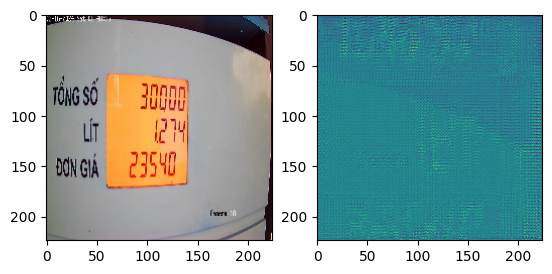

In [4]:
img = cv2.imread(path + data[0])
img = cv2.resize(img, size)
ip = torch.tensor([img]).reshape((1, 3, *size)).to(torch.float32)
print(ip.shape)
out = net(ip)
cc, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(out.cpu().detach().numpy()[:, 0].reshape(size))
plt.show()

In [5]:
out.shape

torch.Size([1, 1, 224, 224])

In [6]:
#define y_true grayscale image, background = 0, interface = 1.
#shape y_true = (batch_size, *size)
def unet_loss(y_true, y_pred):
    y_pred = torch.reshape(y_pred, (batch_size, *size))
    y_pred = torch.sigmoid(y_pred)
    
    inter = y_pred * y_true
    union = y_pred + y_true - inter
    return -(torch.sum(inter) + 1)/(torch.sum(union) + 1)

In [7]:
def get_img(batch_img):
    out = []
    for dt in batch_img:
        img = cv2.imread(path + dt)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        out.append(img)
    return torch.tensor(out).reshape((len(batch_img), 3, *size)).to(device).to(torch.float32)

def get_label(batch_label):
    out = []
    for dt in batch_label:
        img = cv2.imread(path + dt)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
        out.append(img)
    return torch.tensor(out).reshape((len(batch_label), *size)).to(device).to(torch.float32)

In [8]:
list_img = get_img(data)
list_label = get_label([val[:-4] + addon + '.png' for val in data])

In [9]:
list_img.shape

torch.Size([364, 3, 224, 224])

In [22]:
#training
net.to(device)
epochs = 200
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

for epoch in range(epochs):
    all_loss = []
    for i in range(len(data)//batch_size):
        X = list_img[i * batch_size: (i + 1) * batch_size]
        Y = list_label[i * batch_size: (i + 1) * batch_size]
        
        optimizer.zero_grad()
        Y_ = net(X)
        loss = unet_loss(Y, Y_)
        loss.backward()
        optimizer.step()
        all_loss.append(loss)
    all_loss = torch.tensor(all_loss)
    all_loss = torch.mean(all_loss)
    print(f"epoch: {epoch}, loss: {all_loss}")

epoch: 0, loss: -0.9306364059448242
epoch: 1, loss: -0.9311441779136658
epoch: 2, loss: -0.9319571852684021
epoch: 3, loss: -0.932729959487915
epoch: 4, loss: -0.9334619045257568
epoch: 5, loss: -0.9338451027870178
epoch: 6, loss: -0.9347419738769531
epoch: 7, loss: -0.9349952936172485
epoch: 8, loss: -0.9359273910522461
epoch: 9, loss: -0.9362435936927795
epoch: 10, loss: -0.9371099472045898
epoch: 11, loss: -0.9376398324966431
epoch: 12, loss: -0.9382016658782959
epoch: 13, loss: -0.939051628112793
epoch: 14, loss: -0.9396558403968811
epoch: 15, loss: -0.9403476119041443
epoch: 16, loss: -0.9412142038345337
epoch: 17, loss: -0.9417971968650818
epoch: 18, loss: -0.9423304200172424
epoch: 19, loss: -0.9430456757545471
epoch: 20, loss: -0.9435335397720337
epoch: 21, loss: -0.9441600441932678
epoch: 22, loss: -0.944658637046814
epoch: 23, loss: -0.9452007412910461
epoch: 24, loss: -0.945661723613739
epoch: 25, loss: -0.946072518825531
epoch: 26, loss: -0.9465692639350891
epoch: 27, loss:

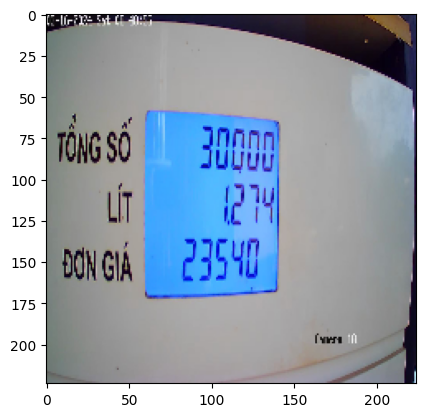

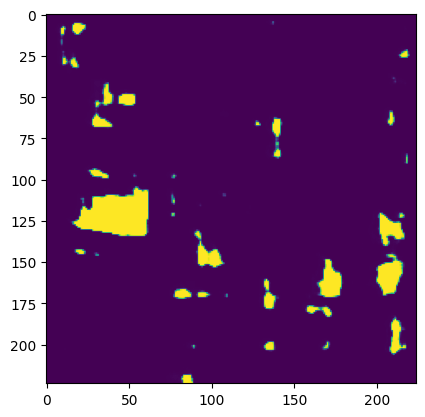

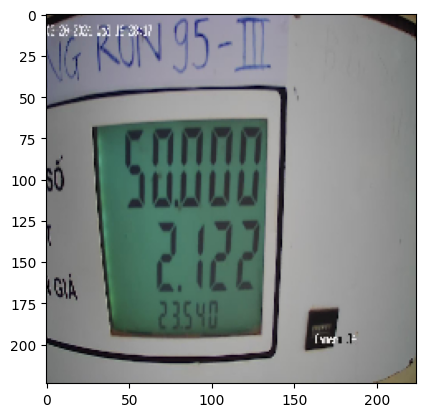

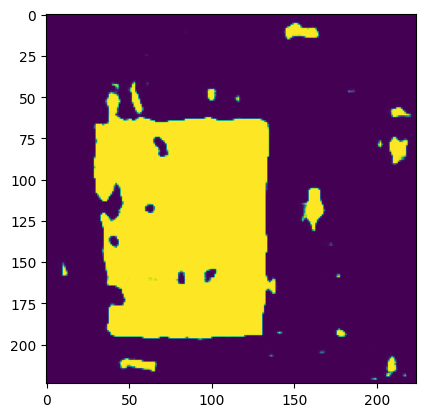

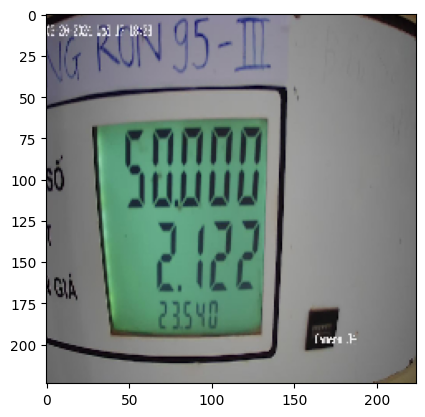

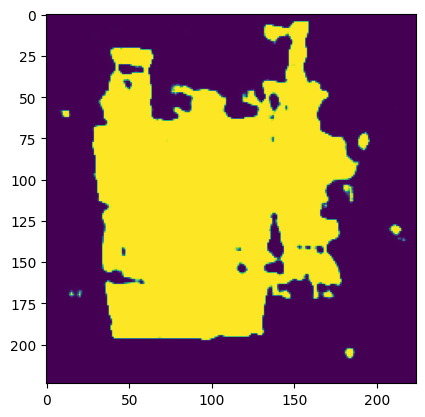

In [24]:
Y_ = net(list_img[:3])
Y_ = torch.sigmoid(Y_)
for i in range(len(Y_)):
    plt.imshow(list_img[i].cpu().reshape(*size, 3)/255)
    plt.show()
    plt.imshow(Y_[i][0].detach().cpu().numpy())
    plt.show()